In [1]:
import os.path as osp
import openslide
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.filters import threshold_otsu

from openslide.deepzoom import DeepZoomGenerator

import cv2
from keras.utils.np_utils import to_categorical

# network

from keras.models import Sequential
from keras.layers import Lambda, Dropout
from keras.layers.convolutional import Convolution2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D

# train

from sklearn.model_selection import StratifiedShuffleSplit
from datetime import datetime

# evaluate

import matplotlib.gridspec as gridspec
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

import math
from PIL import Image
from xml.etree.ElementTree import ElementTree, Element, SubElement
from io import BytesIO

Using TensorFlow backend.


In [2]:
def read_test_data_path():
    image_paths = []
    with open('test.txt','r') as f:
        for line in f:
            line = line.rstrip('\n')
            image_paths.append(line)
    #print('image_path # : ',len(image_paths))
    
    return image_paths


In [3]:
test_image_paths = read_test_data_path()

In [6]:
test_image_paths[2][11:19]

'Slide160'

In [26]:
slide_path = 'data/train/image/positive/Slide003.mrxs'
slide_path = 'data/train/image/negative/Slide001.mrxs'
slide = openslide.open_slide(slide_path)

BASE_TRUTH_DIR = Path('data/train/mask')
truth_path = str(BASE_TRUTH_DIR/'positive/Slide003.png')
truth_path = str(BASE_TRUTH_DIR/'negative/Slide001.png')
truth = openslide.open_slide(truth_path)

print("original slide dimensions %dx%d" % slide.dimensions)
print("original truth dimensions %dx%d" % truth.dimensions)

original slide dimensions 93970x234042
original truth dimensions 5851x7704


In [24]:
!pip install psutil

In [29]:
proc = psutil.Process()
print(proc.open_files())

[popenfile(path='C:\\Windows\\System32\\ko-KR\\kernel32.dll.mui', fd=-1), popenfile(path='C:\\Users\\lalat\\.ipython\\profile_default\\history.sqlite', fd=-1), popenfile(path='C:\\Program Files\\WindowsApps\\Microsoft.LanguageExperiencePackko-kr_17134.22.35.0_neutral__8wekyb3d8bbwe\\Windows\\System32\\ko-KR\\KernelBase.dll.mui', fd=-1), popenfile(path='D:\\ANACONDA\\envs\\tf-gpu\\code\\breast_cancer\\data\\train\\mask\\negative\\Slide001.png', fd=-1)]


In [21]:
openslide

<module 'openslide' from 'd:\\anaconda\\envs\\tf-gpu\\lib\\site-packages\\openslide\\__init__.py'>

In [17]:
slide.close()

In [18]:
(int(slide.properties.get('openslide.bounds-x',0)),int(slide.properties.get('openslide.bounds-y',0)))

ArgumentError: argument 1: <class 'ValueError'>: Passing closed slide object

In [6]:
patch_size = 256

In [7]:
tiles2 = DeepZoomGenerator(slide,tile_size=patch_size, overlap=0, limit_bounds=False)

In [11]:
print(tiles2)

DeepZoomGenerator(OpenSlide('data/train/image/negative/Slide001.mrxs'), tile_size=256, overlap=0, limit_bounds=False)


In [16]:
img = tiles2.get_tile(tiles2.level_count-1, (-10,0))

ValueError: Invalid address

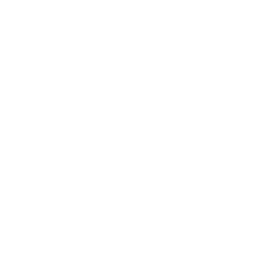

In [14]:
img

In [3]:
truth

ImageSlide('data\\train\\mask\\negative\\Slide001.png')

In [3]:
slide_path_neg = 'data/train/image/negative/Slide001.mrxs'
slide_neg = openslide.open_slide(slide_path_neg)
print("original slide dimensions %dx%d" % slide_neg.dimensions)

original slide dimensions 93970x234042


In [36]:
slide_contains_tumor = 'pos' in slide_path
slide_contains_tumor
BOUNDS_OFFSET_PROPS = (openslide.PROPERTY_NAME_BOUNDS_X, openslide.PROPERTY_NAME_BOUNDS_Y)
BOUNDS_SIZE_PROPS = (openslide.PROPERTY_NAME_BOUNDS_WIDTH, openslide.PROPERTY_NAME_BOUNDS_HEIGHT)
BOUNDS_OFFSET_PROPS
BOUNDS_SIZE_PROPS

('openslide.bounds-width', 'openslide.bounds-height')

In [37]:
start = (int(slide.properties.get('openslide.bounds-x',0)),int(slide.properties.get('openslide.bounds-y',0)))
start

(340, 70272)

In [9]:
patch_size = 256

In [11]:
level = np.log2(patch_size)
level = int(level)
level

8

In [52]:
truth.dimensions

(5316, 10007)

In [22]:
tiles0 = DeepZoomGenerator(slide,tile_size=patch_size, overlap=0, limit_bounds=False)

In [23]:
tiles0

DeepZoomGenerator(OpenSlide('data/train/image/negative/Slide001.mrxs'), tile_size=256, overlap=0, limit_bounds=False)

In [24]:
x,y = 367,914

In [30]:
type(img)

PIL.Image.Image

In [32]:
img = Image.new('RGB', (256, 256))

In [33]:
img.size

(256, 256)

In [38]:
np.array(img).shape

(256, 256, 3)

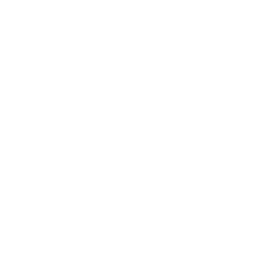

In [28]:
img = tiles0.get_tile(tiles0.level_count-1, (30,30))
img

In [29]:
img.size == (256,256)

True

In [43]:
truth.dimensions

(5851, 7704)

In [44]:
z_dimensions=[]
z_size = truth.dimensions
z_dimensions.append(z_size)
while z_size[0] > 1 or z_size[1] > 1:
    
    z_size = tuple(max(1, int(math.ceil(z / 2))) for z in z_size)
    z_dimensions.append(z_size)

In [45]:
size = z_dimensions[4]

In [51]:
size

(366, 482)

In [46]:
thumbnail_truth = truth.get_thumbnail(size)

In [47]:
start

(340, 70272)

In [48]:
thumbnail_truth.size

(366, 481)

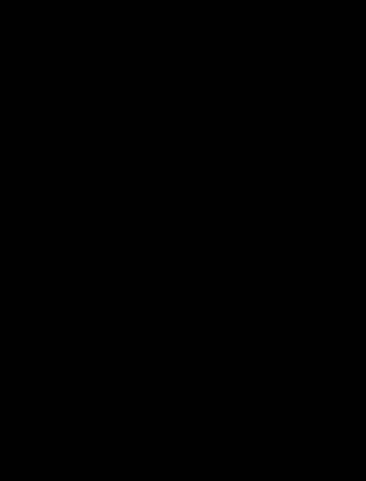

In [52]:
thumbnail_truth

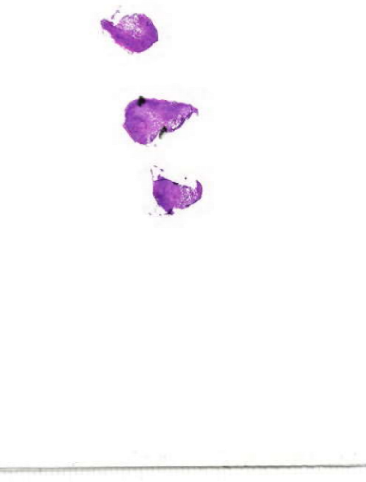

In [53]:
slide4

In [49]:
slide4 = slide.read_region(start,level,size)

In [50]:
slide4.size

(366, 482)